In [35]:
!python --version

Python 3.10.12


In [36]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Jul_11_02:20:44_PDT_2023
Cuda compilation tools, release 12.2, V12.2.128
Build cuda_12.2.r12.2/compiler.33053471_0


In [37]:
!nvidia-smi

Sat Nov 16 06:06:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:07:00.0 Off |                   On |
| N/A   27C    P0             42W /  400W |                  N/A   |     N/A      Default |
|                                         |                        |              Enabled |
+-----------------------------------------+-----

In [38]:
import glob
import zipfile
import shutil
import random
import os
import pathlib

import numpy as np
import pandas as pd
import torch
from torch import cuda
from torch_radon import ParallelBeam
import pydicom
from tqdm import tqdm
import matplotlib.pyplot as plt
import cupy as cp
import cupyx.scipy.ndimage

from typing import Union

In [39]:
ROOT_DATA_PATH='/workspace/datasets'
DATASET_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-hemorrhage-detection.zip'
TRAIN_DATA_PATH='rsna-intracranial-hemorrhage-detection/stage_2_train'
TEST_DATA_PATH='rsna-intracranial-hemorrhage-detection/stage_2_test'
TRAIN_METADATA_PATH='rsna-intracranial-hemorrhage-detection/stage_2_train.csv'
TEST_METADATA_PATH='rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv'

TRAIN_METADATA_SEQ_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-sequence-metadata/train_metadata_noidx.csv'
TEST_METADATA_SEQ_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-sequence-metadata/test_metadata_noidx.csv'

In [40]:
torch_device_target = 'cpu'
if cuda.is_available():
    print('cuda available: ', cuda.is_available())
    print('cuda device count: ', cuda.device_count())
    print('cuda current device: ', cuda.current_device())
    print('cuda device: ', cuda.device(cuda.current_device()))
    print('cuda device name: ', cuda.get_device_name(cuda.current_device()))
    torch_device_target = 'cuda'
else:
    print('running with cuda disabled')
    
device = torch.device(torch_device_target)

cuda available:  True
cuda device count:  1
cuda current device:  0
cuda device:  <torch.cuda.device object at 0x7f00ad0ffeb0>
cuda device name:  NVIDIA A100-SXM4-40GB MIG 1g.10gb


# EDA

In [41]:
dataset_handler = zipfile.ZipFile(DATASET_PATH)

In [42]:
train_metadata = None
with dataset_handler.open(TRAIN_METADATA_PATH) as tm:
    train_metadata = pd.read_csv(tm)
    
train_metadata

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0
...,...,...
4516837,ID_4a85a3a3f_intraparenchymal,0
4516838,ID_4a85a3a3f_intraventricular,0
4516839,ID_4a85a3a3f_subarachnoid,0
4516840,ID_4a85a3a3f_subdural,0


In [43]:
train_metadata[['ID', 'Image', 'Diagnosis']] = train_metadata['ID'].str.split('_', expand=True)
train_metadata = train_metadata[['Image', 'Diagnosis', 'Label']]
train_metadata

,Image,Diagnosis,Label
0,12cadc6af,epidural,0
1,12cadc6af,intraparenchymal,0
2,12cadc6af,intraventricular,0
3,12cadc6af,subarachnoid,0
4,12cadc6af,subdural,0
...,...,...,...
4516837,4a85a3a3f,intraparenchymal,0
4516838,4a85a3a3f,intraventricular,0
4516839,4a85a3a3f,subarachnoid,0
4516840,4a85a3a3f,subdural,0


In [44]:
train_metadata.drop_duplicates(inplace=True)

/tmp/ipykernel_40668/3169812030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_metadata.drop_duplicates(inplace=True)


In [45]:
train_metadata_noidx = pd.read_csv(TRAIN_METADATA_SEQ_PATH)
train_metadata_noidx

,PatientID,StudyInstanceUID,SeriesInstanceUID,ImagePositionPatient,ImageId,ImagePositionSpan
0,ID_6db1b5fc,ID_b7eb78d31c,ID_b007382b3d,"['-125', '19', '404.200073']",ID_c09ea949f,404.200073
1,ID_57a09f4b,ID_eb9443c506,ID_f812e5820a,"['-125.000', '-141.798', '84.610']",ID_1e34867b8,84.610000
2,ID_e2427a9f,ID_dd90fe7eb2,ID_30d7563bac,"['-115.5', '10.5', '-123.5']",ID_5a4ec298b,-123.500000
3,ID_9ddab871,ID_f455cec5a2,ID_0b73424e03,"['-104.5', '7.5', '119.300049']",ID_ba1a35887,119.300049
4,ID_72d26c06,ID_4e6c21f36c,ID_26eca8e83a,"['-125.000000', '-139.940735', '139.171143']",ID_f0e4ebe8d,139.171143
...,...,...,...,...,...,...
752798,ID_6388d679,ID_0be88e0774,ID_decadcf973,"['-125.000', '-118.800', '-20.750']",ID_c6d9d973e,-20.750000
752799,ID_97759401,ID_388fcb7297,ID_6812ec7a72,"['-125', '28', '349.199951']",ID_2b93f7a38,349.199951
752800,ID_49281dd4,ID_d2b12bdfc8,ID_0920fe79a6,"['-125.000', '-121.796', '16.014']",ID_89d85d3d5,16.014000
752801,ID_8163034d,ID_bd5298f232,ID_7e93734db4,"['-125.000', '-93.098', '122.859']",ID_d7dfccfb5,122.859000


In [46]:
train_metadata = train_metadata.pivot(index='Image', columns='Diagnosis', values='Label').reset_index()
train_metadata

Diagnosis,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,000012eaf,0,0,0,0,0,0
1,000039fa0,0,0,0,0,0,0
2,00005679d,0,0,0,0,0,0
3,00008ce3c,0,0,0,0,0,0
4,0000950d7,0,0,0,0,0,0
...,...,...,...,...,...,...,...
752798,ffff82e46,0,0,0,0,0,0
752799,ffff922b9,1,0,0,1,0,0
752800,ffffb670a,1,0,0,0,1,0
752801,ffffcbff8,0,0,0,0,0,0


In [47]:
train_metadata['Image'] = 'ID_' + train_metadata['Image']
train_metadata

Diagnosis,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf,0,0,0,0,0,0
1,ID_000039fa0,0,0,0,0,0,0
2,ID_00005679d,0,0,0,0,0,0
3,ID_00008ce3c,0,0,0,0,0,0
4,ID_0000950d7,0,0,0,0,0,0
...,...,...,...,...,...,...,...
752798,ID_ffff82e46,0,0,0,0,0,0
752799,ID_ffff922b9,1,0,0,1,0,0
752800,ID_ffffb670a,1,0,0,0,1,0
752801,ID_ffffcbff8,0,0,0,0,0,0


In [48]:
merge_train_metadata = pd.merge(left=train_metadata, right=train_metadata_noidx, how='left', left_on='Image', right_on='ImageId')
merge_train_metadata

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,PatientID,StudyInstanceUID,SeriesInstanceUID,ImagePositionPatient,ImageId,ImagePositionSpan
0,ID_000012eaf,0,0,0,0,0,0,ID_f15c0eee,ID_30ea2b02d4,ID_0ab5820b2a,"['-125.000000', '-115.897980', '77.970825']",ID_000012eaf,77.970825
1,ID_000039fa0,0,0,0,0,0,0,ID_eeaf99e7,ID_134d398b61,ID_5f8484c3e0,"['-125.000000', '-141.318451', '62.720940']",ID_000039fa0,62.720940
2,ID_00005679d,0,0,0,0,0,0,ID_18f2d431,ID_b5c26cda09,ID_203cd6ec46,"['-134.463', '-110.785', '-39.569']",ID_00005679d,-39.569000
3,ID_00008ce3c,0,0,0,0,0,0,ID_ce8a3cd2,ID_974735bf79,ID_3780d48b28,"['-125', '-83.0468112', '175.995344']",ID_00008ce3c,175.995344
4,ID_0000950d7,0,0,0,0,0,0,ID_d278c67b,ID_8881b1c4b1,ID_84296c3845,"['-126.437378', '-126.437378', '157.500000']",ID_0000950d7,157.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
752798,ID_ffff82e46,0,0,0,0,0,0,ID_a85c9d08,ID_eca4bf46ac,ID_3ef9b97743,"['-152', '-56', '1011.99995']",ID_ffff82e46,1011.999950
752799,ID_ffff922b9,1,0,0,1,0,0,ID_5964c5e5,ID_b47ca0ad05,ID_6d2a9b2810,"['-126.408875', '-126.408875', '-235.611511']",ID_ffff922b9,-235.611511
752800,ID_ffffb670a,1,0,0,0,1,0,ID_4f7414e4,ID_ffb2e70ba3,ID_87b33b4a10,"['-125.000', '-133.686', '4.725']",ID_ffffb670a,4.725000
752801,ID_ffffcbff8,0,0,0,0,0,0,ID_a5382712,ID_ff0ba45814,ID_bd174db91c,"['-125.000', '-127.453', '35.433']",ID_ffffcbff8,35.433000


In [49]:
df = merge_train_metadata.copy()
ich_y, ich_n = [], []
df.sort_values(['SeriesInstanceUID'])

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,PatientID,StudyInstanceUID,SeriesInstanceUID,ImagePositionPatient,ImageId,ImagePositionSpan
750069,ID_ff1235609,0,0,0,0,0,0,ID_b9797064,ID_00b9e1961f,ID_0000298a7d,"['-125.000', '-147.231', '147.402']",ID_ff1235609,147.402
97725,ID_213346b48,0,0,0,0,0,0,ID_b9797064,ID_00b9e1961f,ID_0000298a7d,"['-125.000', '-147.231', '59.241']",ID_213346b48,59.241
160854,ID_36a144b7a,0,0,0,0,0,0,ID_b9797064,ID_00b9e1961f,ID_0000298a7d,"['-125.000', '-147.231', '202.877']",ID_36a144b7a,202.877
659415,ID_e0276df9e,0,0,0,0,0,0,ID_b9797064,ID_00b9e1961f,ID_0000298a7d,"['-125.000', '-147.231', '76.891']",ID_e0276df9e,76.891
356857,ID_79273c19d,0,0,0,0,0,0,ID_b9797064,ID_00b9e1961f,ID_0000298a7d,"['-125.000', '-147.231', '84.456']",ID_79273c19d,84.456
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15548,ID_0551880d6,0,0,0,0,0,0,ID_984a3f15,ID_7891a70bf4,ID_fffde5ed33,"['-125.000', '-142.652', '147.153']",ID_0551880d6,147.153
170807,ID_3a02787c5,1,0,0,1,0,0,ID_984a3f15,ID_7891a70bf4,ID_fffde5ed33,"['-125.000', '-142.652', '92.615']",ID_3a02787c5,92.615
161916,ID_370208afb,1,0,0,0,1,0,ID_984a3f15,ID_7891a70bf4,ID_fffde5ed33,"['-125.000', '-142.652', '90.008']",ID_370208afb,90.008
682899,ID_e839e863c,0,0,0,0,0,0,ID_984a3f15,ID_7891a70bf4,ID_fffde5ed33,"['-125.000', '-142.652', '61.328']",ID_e839e863c,61.328


In [50]:
merged_metadata_path = os.path.join(ROOT_DATA_PATH, 'rsna-intracranial-sequence-metadata')
os.makedirs(merged_metadata_path, exist_ok=True)
df.to_csv(os.path.join(merged_metadata_path, 'merged_metadata.csv'),index=False)

# Preprocess

In [18]:
def correct_dcm(dcm: pydicom.FileDataset):
    # x = torch.from_numpy(dcm.pixel_array).cuda()
    x = dcm.pixel_array
    x = x + 1000
    px_mode = 4096
    x[x >= px_mode] = x[x >= px_mode] - px_mode
    # dcm.PixelData = x.cpu().numpy().tobytes()
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

In [19]:
def window_image(dcm: pydicom.FileDataset, window_center: int, window_width: int, return_tensor: bool = False):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    # Pixel to Hounsfield Unit (HU)
    # HU=(Pixel Value×RescaleSlope)+RescaleIntercept
    img = torch.from_numpy(dcm.pixel_array).cuda()
    img = img * dcm.RescaleSlope + dcm.RescaleIntercept 
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = torch.clamp(img, img_min, img_max) # np.clip(img, img_min, img_max)
    
    if return_tensor:
        return img
    
    return img.cpu().numpy()

In [20]:
def extract_sinogram(dcm: pydicom.FileDataset, radonobj: ParallelBeam, window: Union['brain', 'subdural', 'soft'] = 'brain') -> list[cp.ndarray, cp.ndarray]: # type: ignore
    im = None
    match window:
        case 'brain':
            brain_img = window_image(dcm, 40, 80, return_tensor=True)
            brain_img = (brain_img - 0) / 80
            im = brain_img
        case 'subdural':
            subdural_img = window_image(dcm, 80, 200, return_tensor=True)
            subdural_img = (subdural_img - (-20)) / 200
            im = subdural_img
        case 'soft':
            soft_img = window_image(dcm, 40, 380, return_tensor=True)
            soft_img = (soft_img - (-150)) / 380
            im = soft_img
        case _:
            raise ValueError('invalid window argument')
            
    im = cp.asarray(im)
    
    bsb_image = im
    
    zoom_factors = 0.5
    bsb_image = cupyx.scipy.ndimage.zoom(bsb_image, zoom_factors) # cv2.resize(bsb_image, (512, 512))
    
    sinogram = None
    # theta = torch.linspace(0., cp.pi, 360).cuda() 
    sinogram = radonobj.forward(torch.as_tensor(bsb_image).cuda()) # np.array(radon(bsb_image, theta=theta, circle=False), dtype=np.float32)
    
    s = sinogram - torch.mean(sinogram)
    s = s/torch.std(sinogram) if torch.std(sinogram) > 0 else s
    
    return (cp.asarray(s), bsb_image)

In [21]:
theta = torch.linspace(0, cp.pi, 256).float().cuda()
radonobj = ParallelBeam(det_count=int(256*cp.sqrt(2)), angles=theta)

In [22]:
sample_dcm_df = df[(df['intraparenchymal'] == 1)].sample(n=1)
# sample_dcm_fname = os.path.join(TRAIN_DATA_PATH, f'{sample_dcm_df["ImageId"].values[0]}.dcm')
sample_dcm_fname = f'{TRAIN_DATA_PATH}/ID_1534bee18.dcm'

with dataset_handler.open(sample_dcm_fname) as dcmf:
    sample_dcm = pydicom.dcmread(dcmf)

original_windowed_img = window_image(sample_dcm, 40, 80)
sample_dcm_df

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,PatientID,StudyInstanceUID,SeriesInstanceUID,ImagePositionPatient,ImageId,ImagePositionSpan
468284,ID_9ed70975c,1,0,1,1,1,0,ID_e17609bb,ID_30dea20adb,ID_4294ea2537,"['-125', '-29', '131.400024']",ID_9ed70975c,131.400024


Text(0.5, 1.0, 'Original Windowed')

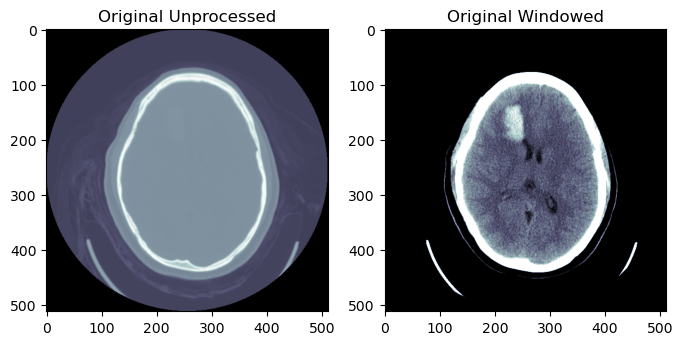

In [23]:
fig, axis = plt.subplots(1, 2, figsize=(8,8))
axis[0].imshow(sample_dcm.pixel_array, cmap=plt.cm.bone)
axis[0].set_title('Original Unprocessed')

axis[1].imshow(original_windowed_img, cmap=plt.cm.bone)
axis[1].set_title('Original Windowed')

Text(0.5, 1.0, 'Subdural Windowed Sinogram')

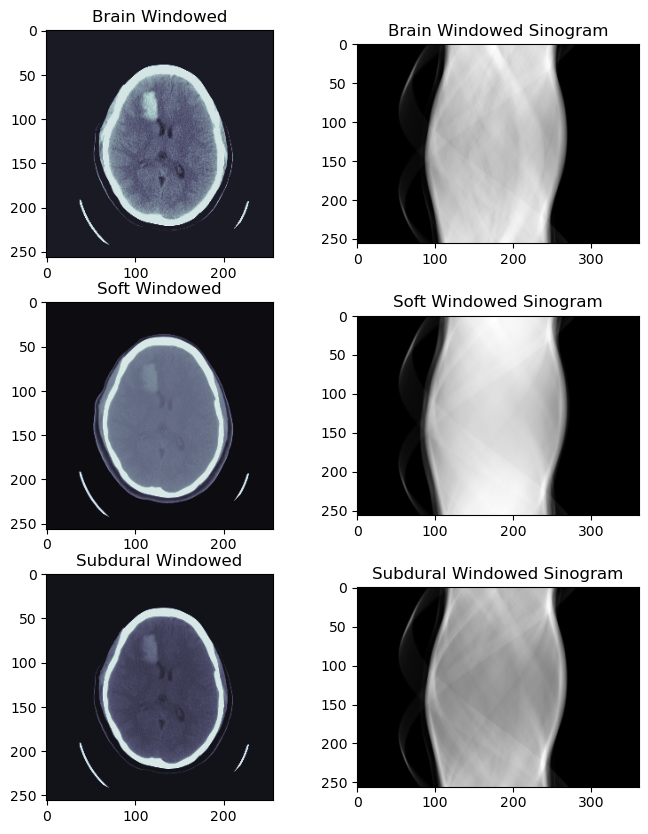

In [24]:
brain_w_sinogram, brain_w = extract_sinogram(sample_dcm, radonobj=radonobj, window='brain')
soft_w_sinogram, soft_w = extract_sinogram(sample_dcm, radonobj=radonobj,window='soft')
subdural_w_sinogram, subdural_w = extract_sinogram(sample_dcm, radonobj=radonobj, window='subdural')

# dx, dy = 0.5 * 180.0 / max(brain_w.shape), 0.5 / brain_w_sinogram.shape[0]

fig, axis = plt.subplots(3, 2, figsize=(8, 10))

axis[0, 0].imshow(brain_w.get(), cmap=plt.cm.bone)
axis[0, 0].set_title('Brain Windowed')
# axis[0, 0].axis('off')
axis[0, 1].imshow(brain_w_sinogram.get(), cmap=plt.cm.Greys_r)
axis[0, 1].set_title('Brain Windowed Sinogram')
# axis[0, 1].axis('off')

axis[1, 0].imshow(soft_w.get(), cmap=plt.cm.bone)
axis[1, 0].set_title('Soft Windowed')
# axis[1, 0].axis('off')
axis[1, 1].imshow(soft_w_sinogram.get(), cmap=plt.cm.Greys_r)
axis[1, 1].set_title('Soft Windowed Sinogram')
# axis[1, 1].axis('off')

axis[2, 0].imshow(subdural_w.get(), cmap=plt.cm.bone)
axis[2, 0].set_title('Subdural Windowed')
# axis[2, 0].axis('off')
axis[2, 1].imshow(subdural_w_sinogram.get(), cmap=plt.cm.Greys_r)
axis[2, 1].set_title('Subdural Windowed Sinogram')
# axis[2, 1].axis('off')

In [25]:
# brain_w_sinogram.nbytes
# print(f"{brain_w_sinogram.nbytes/(1<<20):,.0f} MB")
print(f"{brain_w_sinogram.nbytes/(1<<10):,.0f} KB")
brain_w_sinogram.shape

362 KB


(256, 362)

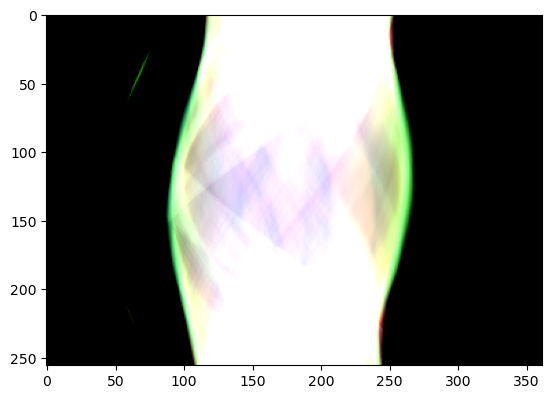

In [66]:
s = cp.clip(cp.stack([brain_w_sinogram, subdural_w_sinogram, soft_w_sinogram], axis=-1), 0, 1)

plt.imshow(s.get(), cmap=plt.cm.Greys_r)
plt.show()

In [26]:
train_series = train_metadata_noidx['SeriesInstanceUID'].unique()
train_series

array(['ID_b007382b3d', 'ID_f812e5820a', 'ID_30d7563bac', ...,
       'ID_949b3e676d', 'ID_3029272c0e', 'ID_707af99316'], dtype=object)

In [33]:
# for i in tqdm(range(len(train_series))):
#     d = df[df['SeriesInstanceUID'] == train_series[i]]
#     if np.sum(d['any']) > 0:
#         ich_y.append(train_series[i])
#     else:
#         ich_n.append(train_series[i])

In [60]:
# os.makedirs('out_data')

In [27]:
# np.savez_compressed('out_data/ich_y_n_train_series.npz', ich_y=ich_y, ich_n=ich_n)
compressed_train_series = np.load(os.path.join(ROOT_DATA_PATH, 'ich-y-n-train-series/ich_y_n_train_series.npz'))
ich_y = compressed_train_series['ich_y']
ich_n = compressed_train_series['ich_n']

In [28]:
train = ich_y[3000:3800]
valid = ich_y[3800:3900]
test = ich_y[3900:4000]

train_df = merge_train_metadata[merge_train_metadata['SeriesInstanceUID'].isin(train)]
valid_df = merge_train_metadata[merge_train_metadata['SeriesInstanceUID'].isin(valid)]
test_df = merge_train_metadata[merge_train_metadata['SeriesInstanceUID'].isin(test)]

In [29]:
# train_df.to_csv('out_data/train800.csv', index=False)
# valid_df.to_csv('out_data/valid100.csv', index=False)
# test_df.to_csv('out_data/test100.csv', index=False)

train_df = pd.read_csv(os.path.join(ROOT_DATA_PATH, 'train-series-splitted-metadata/train800.csv'))
valid_df = pd.read_csv(os.path.join(ROOT_DATA_PATH, 'train-series-splitted-metadata/valid100.csv'))
test_df = pd.read_csv(os.path.join(ROOT_DATA_PATH, 'train-series-splitted-metadata/test100.csv'))

print("----train---")
print(train_df['any'].value_counts())

print("----valid---")
print(valid_df['any'].value_counts())

print("----test---")
print(test_df['any'].value_counts())

----train---
any
0    17583
1     9588
Name: count, dtype: int64
----valid---
any
0    2279
1    1230
Name: count, dtype: int64
----test---
any
0    2244
1    1145
Name: count, dtype: int64


In [33]:
all_df = pd.concat([train_df, test_df, valid_df])
all_df.count()

Image                   34069
any                     34069
epidural                34069
intraparenchymal        34069
intraventricular        34069
subarachnoid            34069
subdural                34069
PatientID               34069
StudyInstanceUID        34069
SeriesInstanceUID       34069
ImagePositionPatient    34069
ImageId                 34069
ImagePositionSpan       34069
dtype: int64

In [36]:
all_df

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,PatientID,StudyInstanceUID,SeriesInstanceUID,ImagePositionPatient,ImageId,ImagePositionSpan
0,ID_00008ce3c,0,0,0,0,0,0,ID_ce8a3cd2,ID_974735bf79,ID_3780d48b28,"['-125', '-83.0468112', '175.995344']",ID_00008ce3c,175.995344
1,ID_000259ccf,0,0,0,0,0,0,ID_ee4d05e4,ID_127d3011a5,ID_6254afb327,"['-125.000', '-121.815', '187.706']",ID_000259ccf,187.706000
2,ID_000457398,0,0,0,0,0,0,ID_34fffd88,ID_72c127d025,ID_5ad9e0e469,"['-126.437378', '-126.437378', '62.500000']",ID_000457398,62.500000
3,ID_0005de569,0,0,0,0,0,0,ID_7ab6d7df,ID_b4d83b111f,ID_16801bed0a,"['-125.000', '-97.286', '-1.590']",ID_0005de569,-1.590000
4,ID_0006441d0,0,0,0,0,0,0,ID_4681a956,ID_5b133aa2c0,ID_a9000bdf3b,"['-125.000000', '-122.597977', '177.810806']",ID_0006441d0,177.810806
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3504,ID_ffbea1845,0,0,0,0,0,0,ID_a7eef85b,ID_621b5be0be,ID_201e83b95a,"['-125.000', '-111.718', '119.541']",ID_ffbea1845,119.541000
3505,ID_ffc2a5962,0,0,0,0,0,0,ID_42c400a5,ID_43acfa469a,ID_2096e8e9ce,"['-147', '-8.0808591', '134.445823']",ID_ffc2a5962,134.445823
3506,ID_ffcdb0570,1,1,0,0,1,1,ID_361d0cbc,ID_09e797f58b,ID_e0d1b0ddcc,"['-133', '17.4942934', '200.075604']",ID_ffcdb0570,200.075604
3507,ID_ffd3b910d,0,0,0,0,0,0,ID_8a464b63,ID_277efef392,ID_b4f60833b0,"['-145.5', '-15.5', '691.400024']",ID_ffd3b910d,691.400024


In [42]:
labels = []
for i, row in tqdm(all_df.iterrows(), total=all_df.shape[0]):
    labels.append(list(row.iloc[1:6]))
    
labels = np.array(labels)
labels_count_percolumn = np.sum(labels,axis=0)

print(labels.shape)
print(labels_count_percolumn)

100%|█████████████████████████████████████████████████████████████████| 34069/34069 [00:02<00:00, 13323.14it/s]

(34069, 5)
[11963   464  3821  2977  4017]


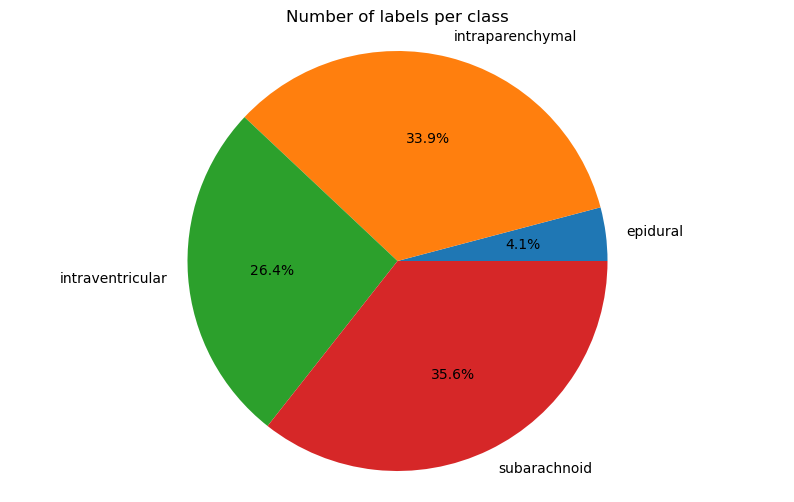

In [51]:
# plot to pie chart
col_names = all_df.columns.to_list()[1:6]

plt.figure(figsize=(10, 6))
plt.pie(labels_count_percolumn[1:], labels=col_names[1:], autopct='%.1f%%')
plt.title('Number of labels per class')
plt.axis('equal')
plt.show()

In [81]:
PROCESSED_SINOGRAM_PATH=f'{ROOT_DATA_PATH}/processed/sinograms'
pathlib.Path(PROCESSED_SINOGRAM_PATH).mkdir(parents=True, exist_ok=True) 

In [41]:
image = cp.zeros((256, 362, 1), dtype=cp.float32)
trainable = np.concatenate((train, valid, test))
for i in tqdm(range(len(trainable))):
    d = df[df['SeriesInstanceUID'] == trainable[i]]
    d.reset_index(inplace = True, drop = True)
    for j in range(d.shape[0]):
        fpath = os.path.join(TRAIN_DATA_PATH, d.loc[j, 'Image'] + '.dcm')
        with dataset_handler.open(fpath) as p:
            dicom = pydicom.dcmread(p)
            bb, _ = extract_sinogram(dicom, radonobj=radonobj, window='brain')
            bb = cp.reshape(bb, (256, 362, 1))
            image[:, :, :] = bb
            cp.save(f"{PROCESSED_SINOGRAM_PATH}/{str(d.loc[j, 'Image'])}.npy", image)

100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [06:01<00:00,  2.76it/s]
